In [9]:
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import numpy as np
import pickle
import time

from games.foraging import Foraging
from agents.iql_agent import IQLAgent, IQLAgentConfig

In [10]:
game_config = [
        "Foraging-5x5-2p-1f-v3",
        "Foraging-8x8-2p-1f-v3",
        "Foraging-8x8-3p-1f-v3",
        "Foraging-8x8-3p-1f-coop-v3",
    ]

In [11]:
configurations = {
    '0': {
        'game': game_config[0],
        'iql': IQLAgentConfig(
            lr=0.1,           # α (learning rate)
            gamma=0.9,        # factor de descuento
            epsilon=1.0,      # ε inicial de exploración
            epsilon_decay=0.99,  # decaimiento de ε por paso
            exploring=True,
            seed=1
        ),
        'train_config': {
            'episodes': 10000,
            'iterations': 10,
        }
    },
    '1': {
        'game': game_config[1],
        'iql': IQLAgentConfig(
            lr=0.1,
            gamma=0.9,
            epsilon=1.0,
            epsilon_decay=0.995,
            exploring=True,
            seed=1
        ),
        'train_config': {
            'episodes': 10000,
            'iterations': 100,
        }
    },
    '2': {
        'game': game_config[2],
        'iql': IQLAgentConfig(
            lr=0.1,
            gamma=0.9,
            epsilon=1.0,
            epsilon_decay=0.998,
            exploring=True,
            seed=1
        ),
        'train_config': {
            'episodes': 10000,
            'iterations': 1000,
        }
    },
    '3': {
        'game': game_config[3],
        'iql': IQLAgentConfig(
            lr=0.1,
            gamma=0.9,
            epsilon=1.0,
            epsilon_decay=0.999,
            exploring=True,
            seed=1
        ),
        'train_config': {
            'episodes': 10000,
            'iterations': 1000,
        }
    }
}

In [12]:
def play_episode(game, agents, verbose=False, render=False):

    # Initialize the game
    game.reset()
    step_count = 0

    # Initialize each agent
    for agent in game.agents:
        agents[agent].reset()

    # Print initial observations if verbose is enabled
    if verbose:
        print(f"Step: {step_count}")
        for agent in game.agents:
            print(f"Agent {agent} observe: {game.observe(agent)}")

    # Initialize rewards for each agent
    cum_rewards = dict(map(lambda agent: (agent, 0.0), game.agents))

    # render the game if required
    if render:
        game.render()
        time.sleep(0.5)

    while not game.done():

        step_count += 1
        
        # Get actions from each agent
        actions = {}
        for agent in game.agents:
            actions[agent] = agents[agent].action()
             
        # Perform the actions in the game
        game.step(actions)

        # Update the cum_rewards for each agent
        for agent in game.agents:
            cum_rewards[agent] += game.reward(agent)

        # Print actions, rewards and next state if verbose is enabled
        if verbose:
            print(f"Step: {step_count}")
            for agent in game.agents:
                    print(f"Agent {agent} action: {actions[agent]} - {game.action_set[actions[agent]]}")
                    print(f"Agent {agent} reward: {game.reward(agent)}")
                    print(f"Agent {agent} observe: {game.observe(agent)}")
            
        if render:
            game.render()
            time.sleep(0.5)
    
        for agent in game.agents:
            # Update the agent with the last observation
            agents[agent].update()
    
    return cum_rewards

In [13]:
def run(game, agents, episodes=1, verbose=False, render=False):
    sum_rewards = dict(map(lambda agent: (agent, 0.0), game.agents))
    for _ in range(episodes):
        cum_rewards = play_episode(game, agents, verbose=verbose, render=render)  
        for agent in game.agents:
            sum_rewards[agent] += cum_rewards[agent]
    if verbose:
        print(f"Average rewards over {episodes} episodes:")
        for agent in game.agents:
            print(f"Agent {agent}: {sum_rewards[agent] / episodes}")  
    return sum_rewards     

In [ ]:
def train(game, agents, train_config, progress=False, verbose=False, render=False, log=False):
    iterations = train_config["iterations"]
    episodes = train_config["episodes"]
    average_rewards = dict(map(lambda agent: (agent, []), game.agents))
    for i in range(1, iterations+1):
        sum_rewards = run(game, agents, episodes=episodes, verbose=verbose, render=render)
        for agent in game.agents:
            average_rewards[agent].append(sum_rewards[agent] / episodes)
        if progress and (i % 10 == 0):
            print(f"Iteration {i} ({i * episodes} episodes)")
            for agent in game.agents:
                print(f"Agent {agent}: {average_rewards[agent][-1]}")
    if progress:
        print(f"Last average rewards over {iterations} iterations ({iterations * episodes} episodes):")
        for agent in game.agents:
            print(f"Agent {agent}: {average_rewards[agent][-1]}")

    return average_rewards

In [15]:
def entrenar_agente_tarea(configurations, config_id, save=False):

    config = configurations[config_id]
    game = Foraging(config=config['game'], seed=1)
    agents = dict(map(lambda agent: (agent, IQLAgent(game=game, agent=agent, config=config['iql'])), game.agents))

    game.reset()
    for agent in game.agents:
        print(f"Agent: {agent}")
        print(f"Observation: {game.observe(agent)}")

    average_rewards = train(game, agents, train_config=config['train_config'], progress=True, verbose=False, render=False)

    resultados_dict = {
        f"experimento_{config_id}": {
            'agents': agents,
            'game': game,
            'config': config,
            'average_rewards': average_rewards
        } 
    }

    with open(f"resultados_{config_id}.pkl", "wb") as f:
        pickle.dump(resultados_dict, f)

    return resultados_dict
    

In [ ]:
# Armar lista de tareas: cada elemento es una tupla (config_id, config)
tareas = [(config_id, config) for config_id, config in configurations.items() if config_id == '0']

# Número de procesos (podés limitarlo si querés)
n_proc = min(len(tareas), cpu_count())

with Pool(processes=n_proc) as pool:
    resultados = pool.map(entrenar_agente_tarea, tareas)

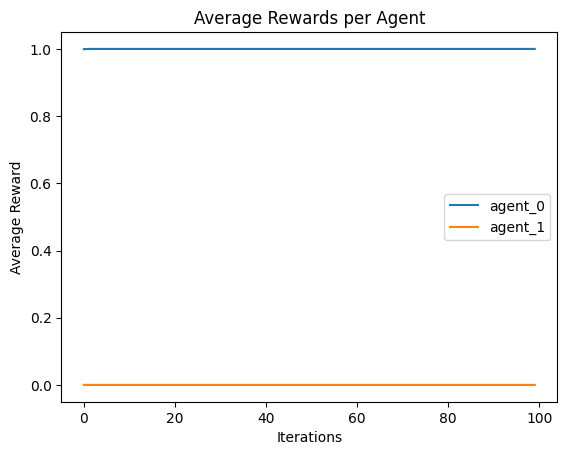

In [ ]:
for agent, rewards in average_rewards.items():
    plt.plot(rewards, label=agent)

plt.xlabel('Iterations')
plt.ylabel('Average Reward')
plt.title('Average Rewards per Agent')
plt.legend()
plt.show()

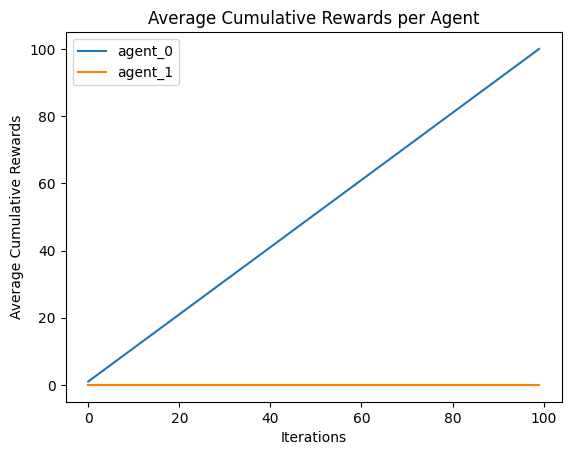

In [ ]:
for agent, rewards in average_rewards.items():
    plt.plot(np.cumsum(rewards), label=agent)

plt.xlabel('Iterations')
plt.ylabel('Average Cumulative Rewards')
plt.title('Average Cumulative Rewards per Agent')
plt.legend()
plt.show()

In [ ]:
for agent in game.agents:
    agents[agent].learn = False

In [ ]:
play_episode(game, agents, verbose=True, render=True)

Step: 0
Agent agent_0 observe: [3. 1. 2. 2. 3. 2. 0. 0. 2.]
Agent agent_1 observe: [3. 1. 2. 0. 0. 2. 2. 3. 2.]
Step: 1
Agent agent_0 action: 3 - WEST
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 2. 2. 2. 2. 0. 0. 2.]
Agent agent_1 action: 3 - WEST
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 1. 2. 0. 0. 2. 2. 2. 2.]
Step: 2
Agent agent_0 action: 3 - WEST
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 2. 2. 1. 2. 0. 0. 2.]
Agent agent_1 action: 1 - NORTH
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 1. 2. 0. 0. 2. 2. 1. 2.]
Step: 3
Agent agent_0 action: 2 - SOUTH
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 2. 2. 1. 2. 1. 0. 2.]
Agent agent_1 action: 2 - SOUTH
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 1. 2. 1. 0. 2. 2. 1. 2.]
Step: 4
Agent agent_0 action: 5 - LOAD
Agent agent_0 reward: 1.0
Agent agent_0 observe: [-1. -1.  0.  2.  1.  2.  1.  0.  2.]
Agent agent_1 action: 5 - LOAD
Agent agent_1 reward: 0
Agent agent_1 observe: [-1. -1.  0.  1

{'agent_0': 1.0, 'agent_1': 0.0}